In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline

import importlib

from tqdm import tqdm

In [2]:
# Importing more libraries for Magnetic coordinates and time calculation

# import pyIGRF as pyigrf

import apexpy
from apexpy import Apex


In [3]:
# Storing the Data collected by satellite

satlocdf = xr.open_dataset('/petastore/phil/Prasoon_satellite_project/sat_files_for_phil/20130317/F16.nc')
satlocdf

<xarray.Dataset>
Dimensions:    (sami_time: 597, sat_time: 4320)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:39:54
    glat       (sat_time) float64 ...
    glon       (sat_time) float64 ...
  * sat_time   (sat_time) datetime64[ns] 2013-03-16 ... 2013-03-18T23:59:00
Data variables:
    e_dens     (sami_time, sat_time) float64 ...

In [4]:
alt = 850
mlat = []
mlon = []

# Introducing the MLAT, MLON, MLT columns in satlocddf
for glat, glon, gtime in tqdm(zip(satlocdf.glat, satlocdf.glon, satlocdf.sat_time), total=len(satlocdf.glon)):

    glon = glon.values
    glat = glat.values
    gtime = gtime.values
    #print(type(gtime))

    date_str = (np.datetime_as_string(gtime))[:19]
    # print(date_str)
    # print(type(date_str))
    format_string = "%Y-%m-%dT%H:%M:%S"
    dtime = datetime.strptime(date_str, format_string)
    
    apex = Apex(dtime)
    #print(apex)
    magfield = apex.convert(glat, glon, 'geo', 'apex')
    
    mlatitude, mlongitude = magfield
    mlat.append(mlatitude)
    mlon.append(mlongitude)
    #satlocdf['mlt'].append(mlt)

satlocdf['mlat'] = ('sat_time', mlat)
satlocdf['mlon'] = ('sat_time', mlon)

100%|██████████████████████████████████████| 4320/4320 [00:19<00:00, 217.67it/s]


<class 'xarray.core.dataset.Dataset'>
Data variables:
    e_dens   (sami_time, sat_time) float64 ...
    mlat     (sat_time) float64 11.47 14.87 18.28 21.7 ... 45.75 42.2 38.49
    mlon     (sat_time) float64 -27.5 -28.59 -29.78 -30.97 ... 166.2 164.6 163.2


100%|██████████████████████████████████████| 4319/4319 [00:10<00:00, 401.66it/s]


Indices of Point Nearest to MLAT = +50: 
 [12, 33, 116, 135, 219, 237, 322, 339, 424, 441, 526, 544, 627, 648, 729, 750, 831, 851, 933, 951, 1034, 1052, 1136, 1153, 1236, 1255, 1337, 1358, 1439, 1460, 1543, 1562, 1646, 1664, 1749, 1766, 1851, 1868, 1953, 1971, 2054, 2075, 2156, 2177, 2258, 2278, 2360, 2379, 2462, 2479, 2563, 2581, 2663, 2682, 2764, 2785, 2866, 2887, 2970, 2989, 3073, 3091, 3176, 3193, 3278, 3295, 3380, 3398, 3481, 3502, 3583, 3604, 3685, 3705, 3787, 3806, 3889, 3907, 3990, 4008, 4091, 4109, 4191, 4212, 4293, 4314]


Indices of Point Nearest to MLAT = -50: 
 [63, 81, 167, 185, 271, 289, 375, 393, 478, 496, 579, 598, 680, 700, 781, 801, 881, 902, 982, 1002, 1082, 1103, 1183, 1203, 1285, 1304, 1387, 1406, 1490, 1508, 1594, 1611, 1698, 1715, 1802, 1819, 1905, 1923, 2006, 2025, 2108, 2127, 2208, 2228, 2309, 2329, 2409, 2430, 2509, 2530, 2610, 2630, 2712, 2731, 2814, 2833, 2917, 2935, 3020, 3038, 3124, 3142, 3229, 3246, 3332, 3350, 3434, 3452, 3535, 3554, 3635, 3656, 3736, 3

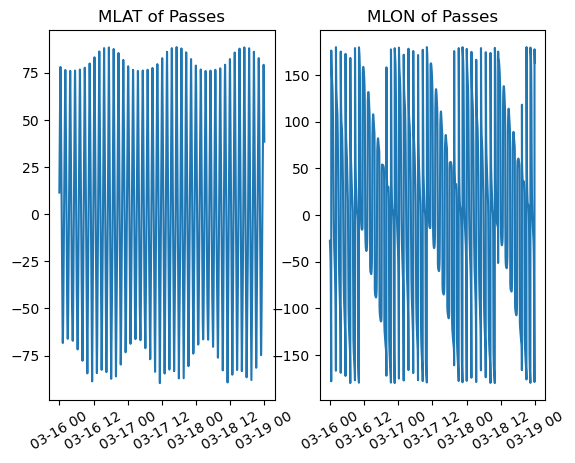

In [5]:
print(type(satlocdf))
print(satlocdf.data_vars)

n_mlat = []
s_mlat = []

for i in tqdm(range(len(satlocdf['mlat'])-1)):
    if (satlocdf['mlat'][i] >= 55 and satlocdf['mlat'][i+1] < 55) or (satlocdf['mlat'][i] <= 55 and satlocdf['mlat'][i+1] > 55):
        n_mlat.append(i)
    if (satlocdf['mlat'][i] >= -55 and satlocdf['mlat'][i+1] < -55) or (satlocdf['mlat'][i] <= -55 and satlocdf['mlat'][i+1] > -55):
        s_mlat.append(i)
        
print('Indices of Point Nearest to MLAT = +50: \n', n_mlat)
print('\n\nIndices of Point Nearest to MLAT = -50: \n', s_mlat)

print('\n len(north): ',len(n_mlat), '\n len(south): ', len(s_mlat))

fig, axs = plt.subplots(1,2)

axs[0].plot(satlocdf['sat_time'], satlocdf['mlat'])
axs[0].set_title('MLAT of Passes')

axs[1].plot(satlocdf['sat_time'], satlocdf['mlon'])
axs[1].set_title('MLON of Passes')

for ax in axs.flatten():
    plt.setp(ax.get_xticklabels(), rotation=30) # rotate x-ticks by 30 degrees so they're readable
    

plt.show()



Date & time of start of First Pass on 17th -
2013-03-17T00:20:00.000000000



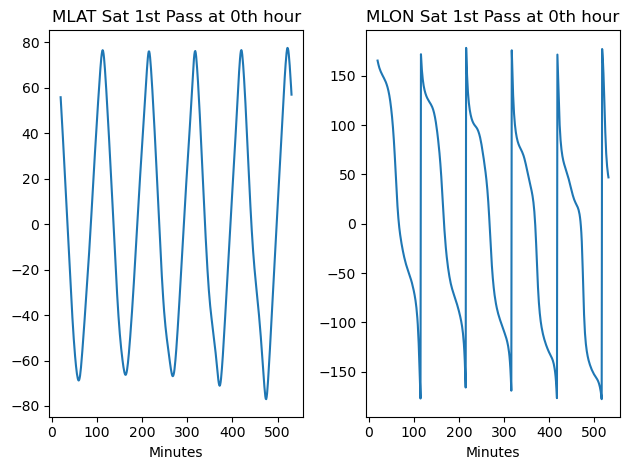

In [14]:
index_n = 29 # 29 is the first satellite pass. 37 is another good one which happens at 7AM
ind_n_mlat = n_mlat[index_n]
ind_s_mlat = 0

if ind_s_mlat == 0:
    for i in s_mlat:
        ind_s_mlat = i
        if i >= ind_n_mlat:
            break         

ind_fin = range(ind_n_mlat,ind_s_mlat+1)
starting_hour = satlocdf['sat_time'][ind_n_mlat].dt.hour.values

print('Date & time of start of First Pass on 17th -')
print(satlocdf['sat_time'][ind_n_mlat].values)
print()
'''
time_pass = []
for i in ind_fin:
    time_pass.append(satlocdf['sat_time'][i].dt.time)

time_pass = xr.DataArray(time_pass)
print(time_pass[0])
'''

time_pass = []
for i in satlocdf['sat_time'][ind_fin]:
    time_pass.append((i.dt.minute.values) + 60*(i.dt.hour.values))

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex = True)

axs[0].plot(time_pass, satlocdf['mlat'][ind_fin])
axs[0].set_title('MLAT Sat 1st Pass at ' + str(starting_hour)+ 'th hour')
axs[0].set(xlabel='Minutes')

axs[1].plot(time_pass, satlocdf['mlon'][ind_fin])
axs[1].set_title('MLON Sat 1st Pass at ' + str(starting_hour)+ 'th hour')
axs[1].set(xlabel='Minutes')
plt.tight_layout()


In [15]:
# Obtaining the data from the SAMI regrid file

sami_data = xr.open_mfdataset('/petastore/phil/DMSP_INTERPOLATIONS/interpolated/20130317/GLOBAL_SAMI_REGRID.nc').load()

sami_data

<xarray.Dataset>
Dimensions:  (time: 596, alt: 42, lat: 180, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
  * alt      (alt) int64 150 200 250 300 350 400 ... 2000 2050 2100 2150 2200
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lon, lat, alt) float64 0.0 0.0 0.0 ... 3.544e+03 3.296e+03

In [18]:
interpolated_edens = []
sami_start = 0
sami_end = 0

for i in range(len(sami_data['time'])-1):

    date_sami = sami_data['time'][i]
    
    if date_sami.dt.day.values == 17:
        if date_sami.dt.hour.values == starting_hour:
            minute_sami = date_sami.dt.minute.values
            
            if minute_sami <= time_pass[0] and (minute_sami+5) > time_pass[0]:
                sami_start = i
            if minute_sami <= time_pass[-1] and (minute_sami+5) > time_pass[-1]:
                sami_end = i
                break

print('Sami starting and ending indices-', sami_start, sami_end, '\n')


sami_pass = sami_data['time'][sami_start:sami_end+1]
sami_pass_min = (sami_pass.dt.minute.values) + 60*(sami_pass.dt.hour.values) + (sami_pass.dt.second.values)%60
#print(sami_pass_min)
interpolated_edens = []

for i in ind_fin:
    sami_iter = []

    for j in sami_pass.values:
        sami_iter.append(float(sami_data.sel(lat=satlocdf['glat'][i].values, 
                                             lon=satlocdf['glon'][i].values, 
                                             alt=alt, method='nearest').edens.interp(time=j).values))
    print(sami_iter, sami_pass_min)
    cs = CubicSpline(sami_pass_min, sami_iter)
    #print(i)
    #print(sami_pass_min, sami_iter)
    
    time_sat = (satlocdf['sat_time'][i].dt.minute.values) + 60*(satlocdf['sat_time'][i].dt.hour.values) + (satlocdf['sat_time'][i].dt.second.values)/60
    #print(time_sat)
    interpolated_edens.append(cs(satlocdf['sat_time'][i].dt.minute.values))

print('Size of non-zero edens added-', np.size(interpolated_edens))
single_pass_sat = satlocdf.isel(sat_time=slice(ind_n_mlat,ind_s_mlat+1))
single_pass_sat['edens_sami_int'] = ('glat', interpolated_edens) 
single_pass_sat
# print('interpolated_edens', interpolated_edens)

Sami starting and ending indices- 292 0 

[] []


ValueError: `x` must contain at least 2 elements.

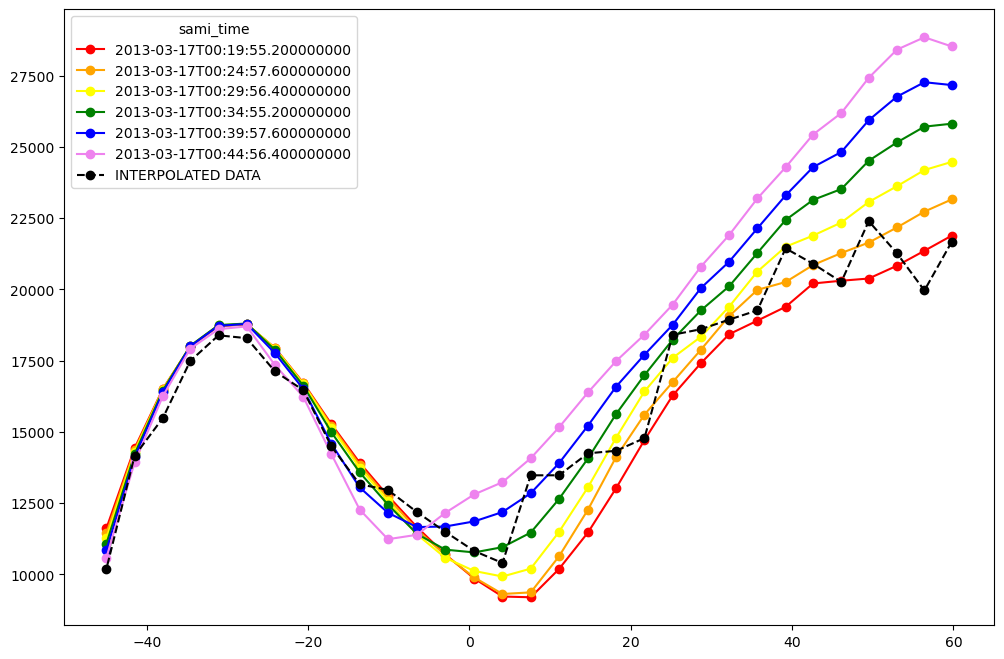

<xarray.Dataset>
Dimensions:         (sami_time: 597, sat_time: 31, glat: 31)
Coordinates:
  * sami_time       (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:3...
    glat            (sat_time) float64 59.8 56.4 53.0 49.5 ... -38.0 -41.5 -45.0
    glon            (sat_time) float64 ...
  * sat_time        (sat_time) datetime64[ns] 2013-03-17T00:20:00 ... 2013-03...
Data variables:
    e_dens          (sami_time, sat_time) float64 ...
    mlat            (sat_time) float64 55.89 52.49 49.04 ... -47.36 -50.37 -53.2
    mlon            (sat_time) float64 165.3 163.1 161.2 ... 124.3 120.9 117.0
    edens_sami_int  (glat) float64 2.168e+04 1.996e+04 ... 1.416e+04 1.019e+04

In [38]:
plt.figure(figsize=(12,8))

colors=['red', 'orange', 'yellow', 'green', 'blue', 'violet']


for i_sami_time in range(sami_start, sami_end):
    plt.plot(single_pass_sat.glat, 
                single_pass_sat.e_dens.isel(sami_time=i_sami_time), 
                label=single_pass_sat.sami_time.values[i_sami_time],
            c=colors[i_sami_time-sami_start], marker = 'o')
    
plt.plot(single_pass_sat.glat, single_pass_sat.edens_sami_int, label='INTERPOLATED DATA', linestyle='--', marker = 'o', c='k')
    
plt.legend(title='sami_time')
plt.show()

single_pass_sat

Text(0.5, 1.0, 'Satellite First Pass')

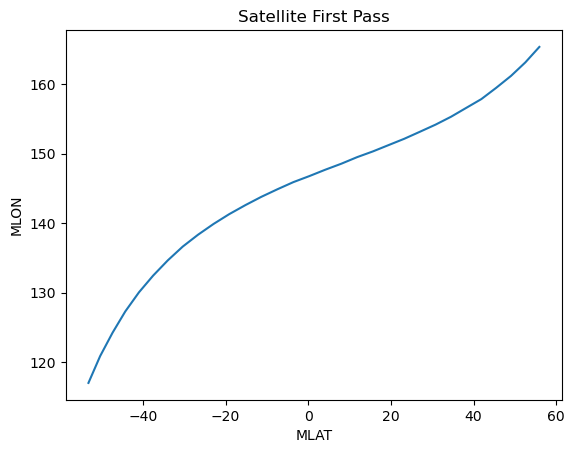

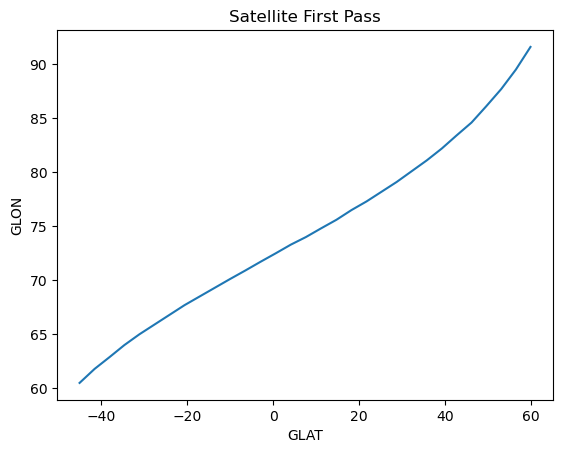

In [10]:
plt.figure()
plt.plot(single_pass_sat.mlat, single_pass_sat.mlon)
plt.xlabel('MLAT')
plt.ylabel('MLON')
plt.title('Satellite First Pass')

plt.figure()
plt.plot(single_pass_sat.glat, single_pass_sat.glon)
plt.xlabel('GLAT')
plt.ylabel('GLON')
plt.title('Satellite First Pass')

First image is the edens of sami_data only during satellite pass at alt = 850 and mlon = mlon_avg 

Second image is the altitude-integrated edens of sami_data only during satellite pass with mlon = mlon_avg 

Third image is the edens of whole sami_data at alt = 850 and mlon = mlon_avg 

Fourth image is the edens of whole sami_data at alt = 850 and mlon = mlon_avg 



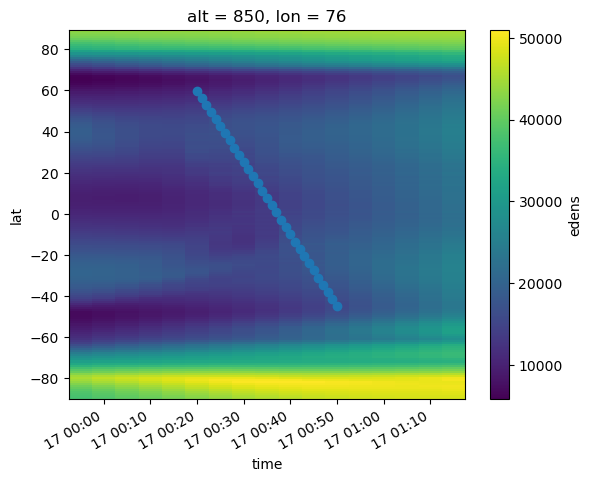

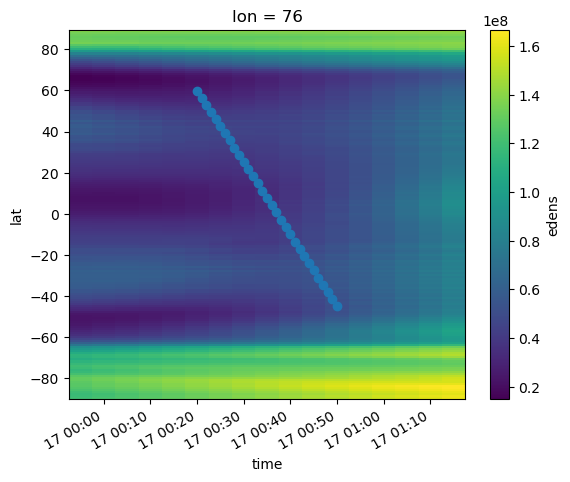

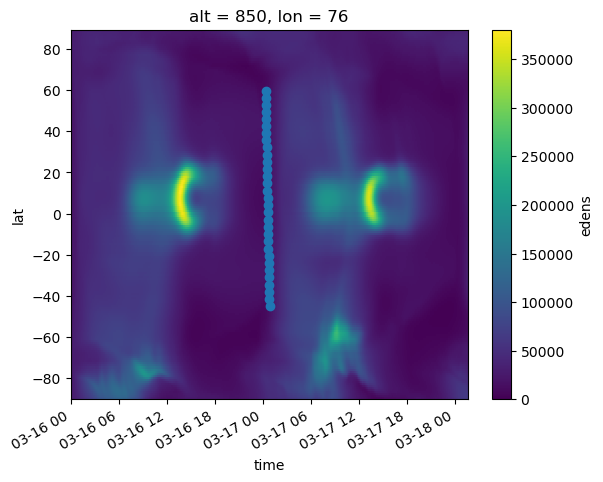

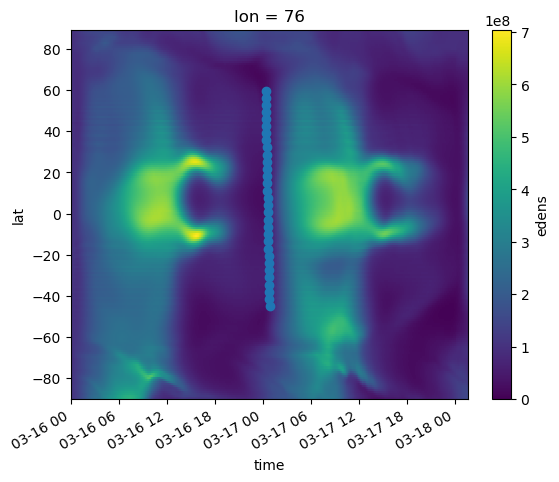

In [11]:
#print(single_pass_sat.dtime, single_pass_sat.glat)

passing_sami = sami_data.isel(time=slice(sami_start-5,sami_end+1+5))
#print(sami_start, sami_end)
#print('time', passing_sami['time'])
#print('latitude', passing_sami['lat'])
#print('longitude', passing_sami['lon'])
#print('altitude', passing_sami['alt'])


glon_avg = single_pass_sat.glon.mean()

print('First image is the edens of sami_data only during satellite pass at alt = 850 and mlon = mlon_avg \n')
passing_sami.edens.sel(alt = alt, lon=glon_avg, method='nearest').plot(x='time')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)

print('Second image is the altitude-integrated edens of sami_data only during satellite pass with mlon = mlon_avg \n')
plt.figure()
passing_sami.edens.sel(lon=glon_avg, method='nearest').integrate('alt').plot(x='time')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)

print('Third image is the edens of whole sami_data at alt = 850 and mlon = mlon_avg \n')
plt.figure()
sami_data.edens.sel(alt = alt, lon=glon_avg, method='nearest').plot(x='time')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)


print('Fourth image is the edens of whole sami_data at alt = 850 and mlon = mlon_avg \n')
plt.figure()
sami_data.edens.sel(lon=glon_avg, method='nearest').integrate('alt').plot(x='time')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)

In [12]:
from scipy.signal import butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt


def filt_filt(da,
              freq=5,
              lims=[40, 85],
              order=1,
              percent=True):

    # Define sampling frequency and limits in minutes
    sampling_freq = freq
    lower_limit = min(lims)
    upper_limit = max(lims)

    # Convert limits to corresponding indices
    lower_index = int(lower_limit / sampling_freq)
    upper_index = int(upper_limit / sampling_freq)

    # Design the bandpass filter
    nyquist_freq = 0.5 * sampling_freq
    lower_cutoff = lower_index / nyquist_freq
    upper_cutoff = upper_index / nyquist_freq
    b, a = butter(order, [1/upper_cutoff, 1/lower_cutoff],
                  btype='band', analog=False)

    # Apply the filter to the data
    filtd = filtfilt(b, a, da, axis=0)
    # filtd = xr.apply_ufunc(filtfilt, b, a, da, dask='allowed')

    if percent:
        return (100*(filtd)/da)

    else:
        da.values = filtd
        return da

/home/axb170054/.conda/envs/s3g/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/axb170054/.conda/envs/s3g/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


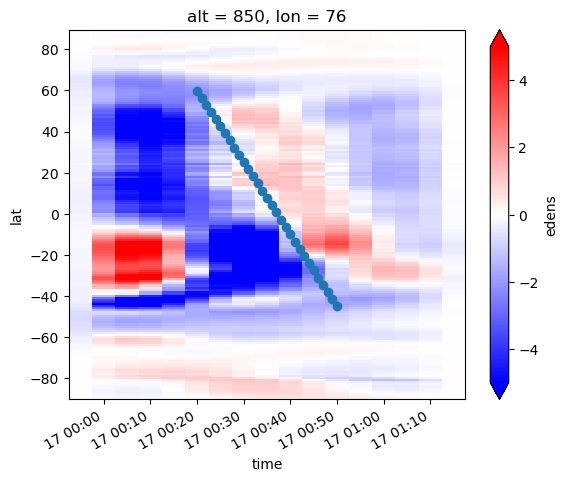

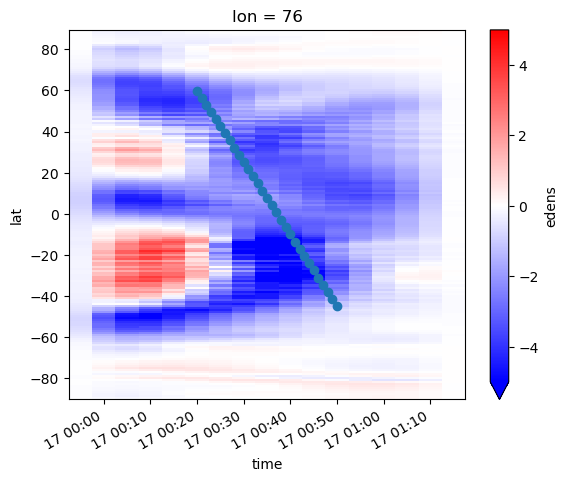

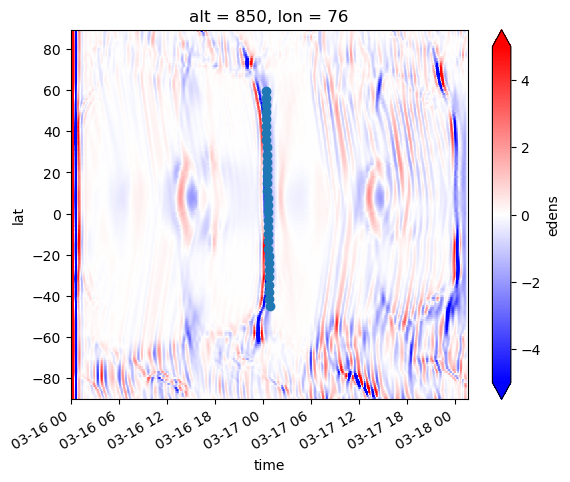

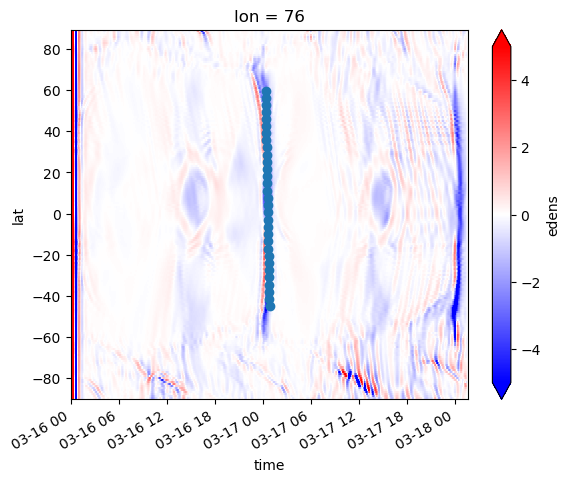

In [13]:

plt.figure()
filt_filt(passing_sami.edens.sel(alt = alt, lon=glon_avg, method='nearest')).plot(x='time', vmin=-5, vmax=5, cmap='bwr')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)

plt.figure()
filt_filt(passing_sami.edens.sel(lon=glon_avg, method='nearest').integrate('alt')).plot(x='time', vmin=-5, vmax=5, cmap='bwr')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)


plt.figure()
filt_filt(sami_data.edens.sel(alt = alt, lon=glon_avg, method='nearest')).plot(x='time', vmin=-5, vmax=5, cmap='bwr')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)

plt.figure()
filt_filt(sami_data.edens.sel(lon=glon_avg, method='nearest').integrate('alt')).plot(x='time', vmin=-5, vmax=5, cmap='bwr')
plt.scatter(single_pass_sat.sat_time, single_pass_sat.glat)

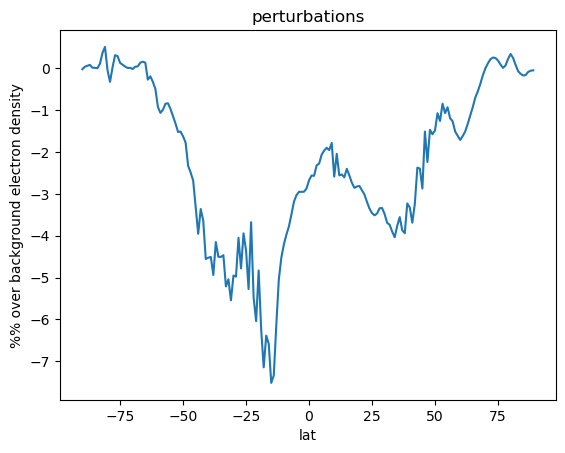

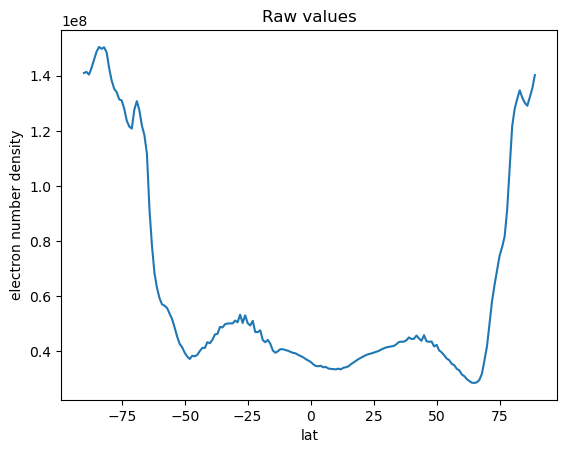

In [14]:
mid = int(len(passing_sami['time'])/2)
#print(mid)
#print(passing_sami['time'])

filt_filt(passing_sami.edens.sel(lon=glon_avg, method='nearest').integrate('alt')).isel(time=mid).plot()
plt.title('perturbations')
plt.ylabel('%% over background electron density')
plt.show()
    

passing_sami.edens.sel(lon=glon_avg, method='nearest').integrate('alt').isel(time=mid).plot()
plt.title('Raw values')
plt.ylabel('electron number density')
plt.show()

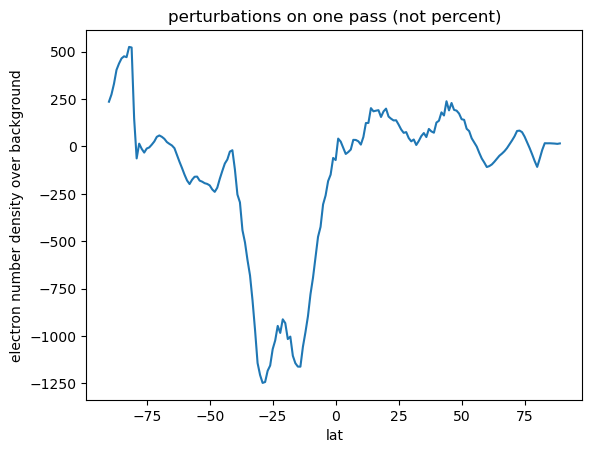

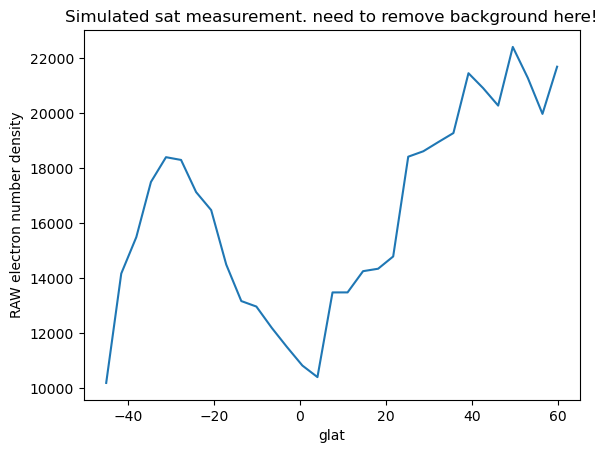

<xarray.Dataset>
Dimensions:         (sami_time: 597, sat_time: 31, glat: 31)
Coordinates:
  * sami_time       (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:3...
    glat            (sat_time) float64 59.8 56.4 53.0 49.5 ... -38.0 -41.5 -45.0
    glon            (sat_time) float64 91.6 89.5 87.7 86.1 ... 62.9 61.8 60.5
  * sat_time        (sat_time) datetime64[ns] 2013-03-17T00:20:00 ... 2013-03...
Data variables:
    e_dens          (sami_time, sat_time) float64 ...
    mlat            (sat_time) float64 55.89 52.49 49.04 ... -47.36 -50.37 -53.2
    mlon            (sat_time) float64 165.3 163.1 161.2 ... 124.3 120.9 117.0
    edens_sami_int  (glat) float64 2.168e+04 1.996e+04 ... 1.416e+04 1.019e+04

In [15]:

filt_filt(passing_sami.edens.sel(lon=glon_avg, method='nearest', alt=850), percent=False).isel(time=mid).plot()
plt.title('perturbations on one pass (not percent)')
plt.ylabel('electron number density over background')
plt.show()


plt.plot(single_pass_sat.glat, single_pass_sat.edens_sami_int)
plt.ylabel('RAW electron number density')
plt.xlabel('glat')
plt.title('Simulated sat measurement. need to remove background here!')
plt.show()

single_pass_sat

# Now for the `.rolling()` stuff:



In [16]:

single_pass_sat['rolled-6'] = single_pass_sat.edens_sami_int.rolling(glat=6, center=True).mean()
single_pass_sat['rolled-4'] = single_pass_sat.edens_sami_int.rolling(glat=4, center=True).mean()



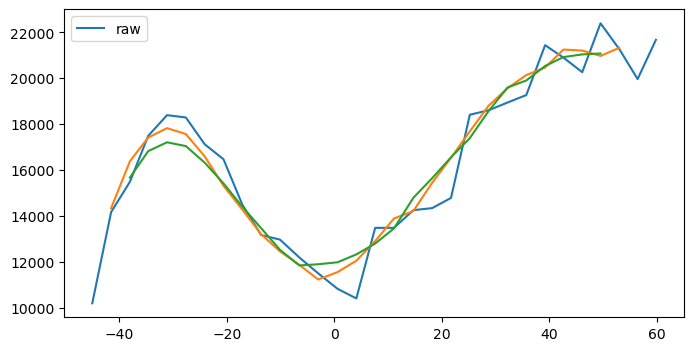

In [17]:
plt.figure(figsize=(8,4))

plt.plot(single_pass_sat.glat, single_pass_sat.edens_sami_int, label='raw')

plt.plot(single_pass_sat.glat, single_pass_sat['rolled-4'])
plt.plot(single_pass_sat.glat, single_pass_sat['rolled-6'])

plt.legend()
plt.show();

## WHAT TO DO:

1. Inside of `/petastore/phil/DMSP_INTERPOLATIONS/interpolated/20130317` there are 3 sat files. Read in `F18_SAT_INTERP.nc` with:
   > xr.open_dataset() 
2. Find the first pass on 2013-03-17. 
3. Make sure inteprolations are working right. I have one example plot, you can also do a plot of one point and a few hours of sami_time (on the x-axis, y-axis is e_dens, then plot the interpolated value as a single point)
    1. After they work for that UT, Add the pass at 04:00 UT, 10:00 UT.
    2. Make sure it still works
4. Start looking at background removal. 
    1. Evaluate options and make plots comnparing
        > Just using the SAT_INTERP file for now...
    2. Find the best few candidates... 00 & 04 UT should be quiet, 10 UT should be close, kind of.
        > perturbations are only a couple of percent, so the fits should be within ~10% of the original data.
    3. More UT's
    4. Different satellite files. Same UT's, or not. You choose.
5. Send to me. We'll work together to look at the SAMI_regrid file


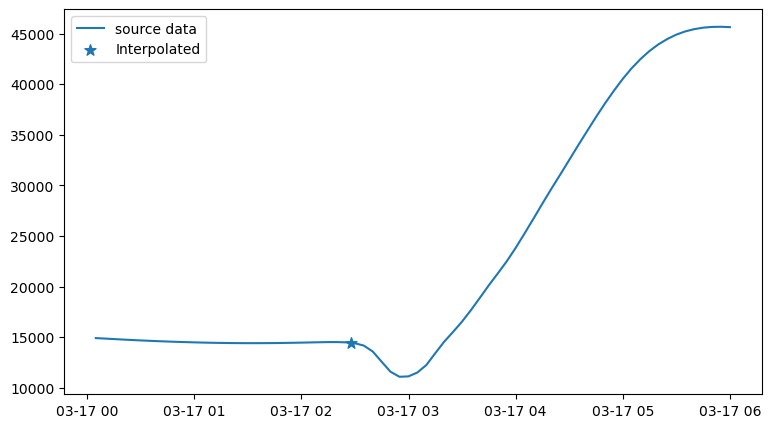

In [39]:
"""
So I started making this cell to give you an example of how I would approach the interpolation problem.
While working on it I found why yours weren't working.


Since you only used the minute value, longer satellite passes have repeated values...
Actually the values might not make any sense.
See the plot in the cell below...


"""



## EXAMPLE PLOT:

# this is just an example of how we can look at one point's evolution over sami_time when looking at the intepolations in time

# Since it's random, each time you run this cell, a new point will be selected and the plot remade.


# In reality we don't want to mask out any points, I'm just doing this to make the plots look nicer & to make sure it's at a time when we have good data.

## Grab the sat_ds with good data (24 hours after sim start & before storm):

sat_ds = satlocdf.where((satlocdf.sami_time>pd.Timestamp('2013-03-17'))
                        & (satlocdf.sami_time<pd.Timestamp('2013-03-17 06:00'))
                        & (satlocdf.sat_time>pd.Timestamp('2013-03-17'))
                        & (satlocdf.sat_time<pd.Timestamp('2013-03-17 06:00')), drop=True)

# random satellite location...
num_of_rand_point = np.random.randint(sat_ds.sat_time.size)

# do the interp'ing, build interpolator with all sami_time points, then interpolate & plot
# I'm bad at interpolating so I dumb it down real far.
xs = sat_ds.sami_time.values
ys = sat_ds.e_dens.isel(sat_time=num_of_rand_point)

x_point_we_want = sat_ds.sat_time.values[num_of_rand_point]

interpolator = CubicSpline(xs, ys)
y_point_we_want = interpolator(x_point_we_want)

plt.figure(figsize=(9, 5))
plt.plot(xs, ys, label='source data')
plt.scatter(x_point_we_want, y_point_we_want, marker='*', s=69, label='Interpolated')
plt.legend()


plt.show()

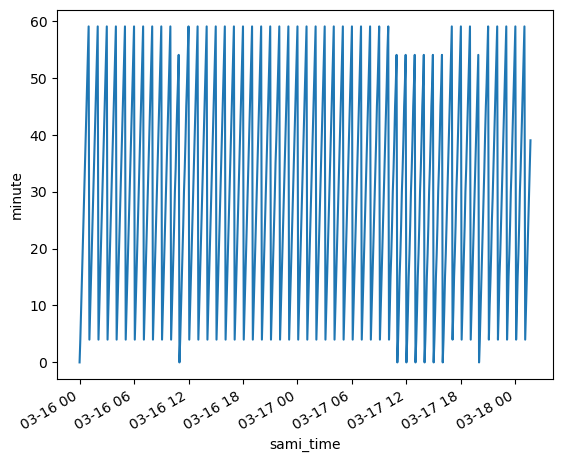

In [19]:
satlocdf.sami_time.dt.minute.plot()